In [51]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from gensim.models import Doc2Vec
from sklearn.manifold import TSNE
%matplotlib inline

Read Dataset

In [52]:
df = pd.read_csv('/content/all-data.csv',delimiter=',',encoding='latin-1')
df.head()

,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [53]:
df = df.rename(columns={'neutral':'sentiment','According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .':'Message'})

In [54]:
df.head(5)

,sentiment,Message
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [55]:
df.shape

(4845, 2)

In [56]:
df.index = range(4845)
df['Message'].apply(lambda x: len(x.split(' '))).sum()

111964

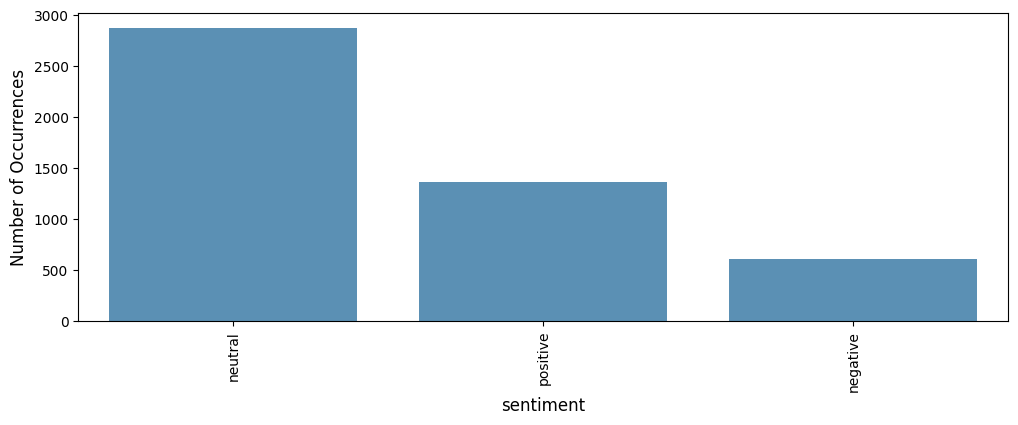

In [57]:
cnt_pro = df['sentiment'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(x=cnt_pro.index, y=cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show()

Convert sting to numeric

In [58]:
sentiment  = {'positive': 0,'neutral': 1,'negative':2}

df.sentiment = [sentiment[item] for item in df.sentiment]
print(df)

      sentiment                                            Message
0             1  Technopolis plans to develop in stages an area...
1             2  The international electronic industry company ...
2             0  With the new production plant the company woul...
3             0  According to the company 's updated strategy f...
4             0  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
...         ...                                                ...
4840          2  LONDON MarketWatch -- Share prices ended lower...
4841          1  Rinkuskiai 's beer sales fell by 6.5 per cent ...
4842          2  Operating profit fell to EUR 35.4 mn from EUR ...
4843          2  Net sales of the Paper segment decreased to EU...
4844          2  Sales in Finland decreased by 10.5 % in Januar...

[4845 rows x 2 columns]


In [59]:
def print_message(index):
    example = df[df.index == index][['Message', 'sentiment']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Message:', example[1])
print_message(12)

Finnish Talentum reports its operating profit increased to EUR 20.5 mn in 2005 from EUR 9.3 mn in 2004 , and net sales totaled EUR 103.3 mn , up from EUR 96.4 mn .
Message: 0


In [60]:
print_message(0)

Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .
Message: 1


Text Preprocessing

Below we define a function to convert text to lower-case and strip punctuation/symbols from words and so on.

In [61]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text)
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['Message'] = df['Message'].apply(cleanText)

<ipython-input-61-aaa97489b476>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


In [62]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [63]:
df['Message'] = df['Message'].apply(cleanText)
train, test = train_test_split(df, test_size=0.000001 , random_state=42)

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)

<ipython-input-61-aaa97489b476>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


In [64]:
# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X)
print('Found %s unique tokens.' % len(X))

Found 4845 unique tokens.


In [65]:
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (4845, 50)


In [66]:
#train_tagged.values[2173]
train_tagged.values

array([TaggedDocument(words=['upm-kymmene', 'has', 'generated', 'four', 'consecutive', 'quarters', 'of', 'positive', 'free', 'cash', 'flow', '.'], tags=[0]),
       TaggedDocument(words=['in', 'the', 'method', 'the', 'smelt', 'spouts', '2', 'are', 'separated', 'from', 'the', 'working', 'area', '6', 'by', 'a', 'shielding', 'wall', '8', ',', '10', 'arranged', 'movable', 'in', 'relation', 'to', 'the', 'smelt', 'spouts', '.'], tags=[1]),
       TaggedDocument(words=['``', 'that', "'s", 'a', 'very', 'high', 'figure', 'on', 'the', 'european', 'scale', ',', '``', 'noop', 'said', ',', 'recalling', 'however', 'that', 'this', 'also', 'includes', 'beer', 'bought', 'by', 'finnish', 'tourists', '.'], tags=[1]),
       ...,
       TaggedDocument(words=['proha', 'plc', '(', 'euronet', ':7327', ')', 'announced', 'today', '(', '19', 'may', ')', 'that', 'its', 'fully-owned', 'subsidiary', ',', 'safran', 'software', 'solutions', 'as', ',', 'has', 'agreed', 'to', 'sell', 'its', '49', '%', 'share', 'of', '

Model DM = 1

In this work use DM=1

it helps to preserve word order

In [67]:
# Initialize the Doc2Vec model
d2v_model = Doc2Vec(dm=1, dm_mean=1, vector_size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)

# Build vocabulary
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 4844/4844 [00:00<00:00, 2014197.34it/s]


In [68]:
print(d2v_model)

Doc2Vec<dm/m,d20,n5,w8,s0.001>


In [69]:
# Get the length of the vocabulary
vocab_size = len(d2v_model.wv.key_to_index)
print(vocab_size)

11682


In [70]:
# Save the vectors in a new matrix
embedding_matrix = np.zeros((vocab_size + 1, 20))

for i, vec in enumerate(d2v_model.dv.vectors):
    if i <= 1000:
        embedding_matrix[i] = vec

print(embedding_matrix)

[[-0.02615408 -0.02989563 -0.04940377 ...  0.04612811 -0.04750933
  -0.01729043]
 [-0.01884955  0.01303691 -0.02845779 ... -0.04271271 -0.01801307
   0.00865813]
 [-0.0102846  -0.03615021  0.020923   ...  0.0176799  -0.02875156
   0.04407407]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


Measuring distance between two vectors (related to cosine similarity)

In [71]:
d2v_model.wv.most_similar(positive=['profit'], topn=10)

[('ultrascan', 0.7394057512283325),
 ('worked', 0.7005417346954346),
 ('1st', 0.6922711730003357),
 ('vaasa', 0.6846891045570374),
 ('teus', 0.6820890307426453),
 ('desktop', 0.6758761405944824),
 ('ferro-chrome', 0.6607208847999573),
 ('introducing', 0.6605374217033386),
 ('term', 0.6594017148017883),
 ('si-year', 0.6559855341911316)]

In [72]:
d2v_model.wv.most_similar(positive=['investment'], topn=10)

[('1,800', 0.7331563830375671),
 ('pm', 0.7195544242858887),
 ('8.8', 0.6821318864822388),
 ('leipurin', 0.6775318384170532),
 ('liters', 0.6681678295135498),
 ('121.4', 0.6568304896354675),
 ('china', 0.6516955494880676),
 ('non-recurring', 0.6349445581436157),
 ('nefarious', 0.6328309774398804),
 ('rautakesko', 0.6292448043823242)]

In [73]:
d2v_model.wv.most_similar(positive=['broke'], topn=10)

[('hassles', 0.7287212014198303),
 ('lakshmi', 0.7039442658424377),
 ('deere', 0.6906518340110779),
 ('surfaces', 0.68013995885849),
 ('efi', 0.6747086644172668),
 ('eaton', 0.6721409559249878),
 ('slovak', 0.6695188879966736),
 ('19.1', 0.6663731336593628),
 ('shared', 0.6656529903411865),
 ('consumer', 0.6616621613502502)]

Plot Similarity word in Doc2vec

In [74]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.index_to_key:
        tokens.append(model.wv[word])
        labels.append(word)

    tokens = np.array(tokens)  # Convert tokens to a numpy array

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=250, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 147 (\x93) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 136 (\x88) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 139 (\x8b) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 151 (\x97) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


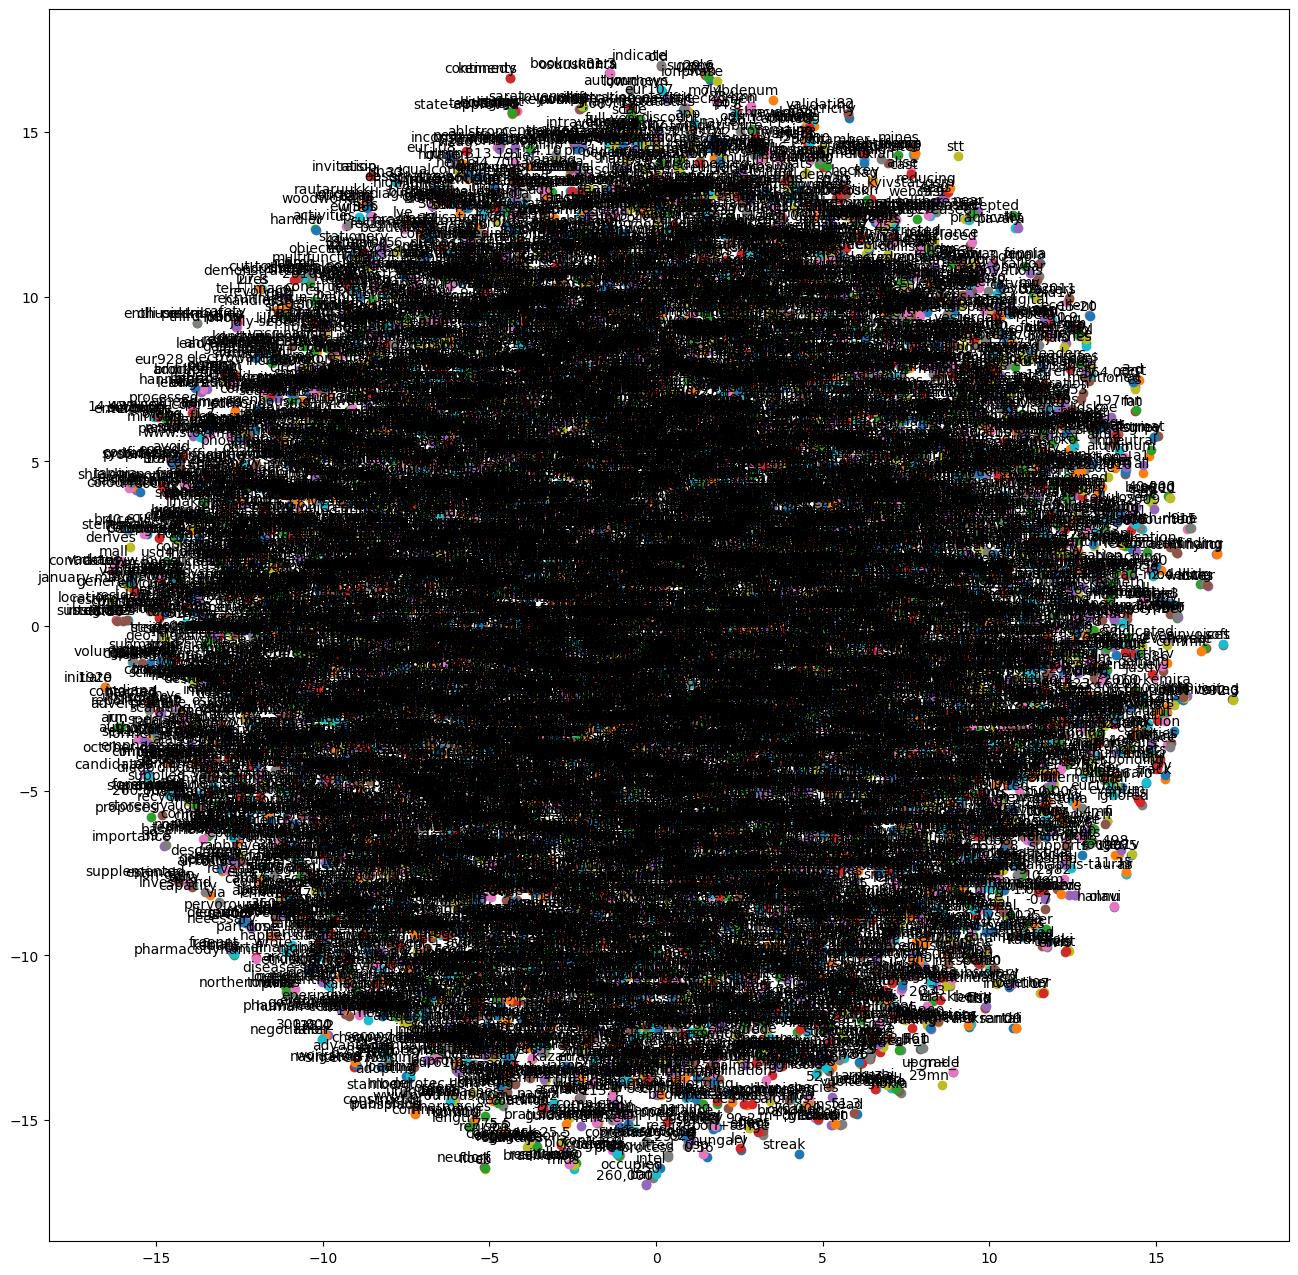

In [75]:
tsne_plot(d2v_model)

# LSTM Model

In [77]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
import tensorflow as tf

# init layer
model = Sequential()

# Get the vocabulary size
vocab_size = len(d2v_model.wv.key_to_index)

# embed word vectors
model.add(Embedding(vocab_size + 1, 20, input_length=X.shape[1], weights=[embedding_matrix], trainable=True))

# learn the correlations
def split_input(sequence):
    return sequence[:-1], tf.reshape(sequence[1:], (-1, 1))

model.add(LSTM(50, return_sequences=False))
model.add(Dense(3, activation="softmax"))

# output model skeleton
model.summary()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 20)            233660    
                                                                 
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 248013 (968.80 KB)
Trainable params: 248013 (968.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


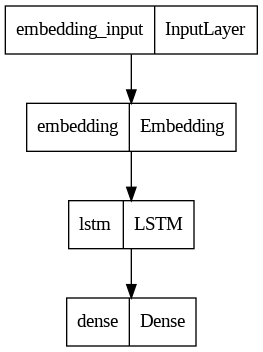

In [78]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [79]:
Y = pd.get_dummies(df['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4118, 50) (4118, 3)
(727, 50) (727, 3)


In [80]:
batch_size = 32
history=model.fit(X_train, Y_train, epochs =50, batch_size=batch_size, verbose = 2)

Epoch 1/50
129/129 - 15s - loss: 0.5446 - acc: 0.6078 - 15s/epoch - 119ms/step
Epoch 2/50
129/129 - 5s - loss: 0.4193 - acc: 0.7047 - 5s/epoch - 42ms/step
Epoch 3/50
129/129 - 2s - loss: 0.3072 - acc: 0.7950 - 2s/epoch - 19ms/step
Epoch 4/50
129/129 - 3s - loss: 0.2314 - acc: 0.8358 - 3s/epoch - 23ms/step
Epoch 5/50
129/129 - 2s - loss: 0.1564 - acc: 0.9094 - 2s/epoch - 12ms/step
Epoch 6/50
129/129 - 1s - loss: 0.0889 - acc: 0.9560 - 1s/epoch - 11ms/step
Epoch 7/50
129/129 - 1s - loss: 0.0634 - acc: 0.9728 - 1s/epoch - 11ms/step
Epoch 8/50
129/129 - 2s - loss: 0.0440 - acc: 0.9832 - 2s/epoch - 17ms/step
Epoch 9/50
129/129 - 1s - loss: 0.0304 - acc: 0.9886 - 1s/epoch - 10ms/step
Epoch 10/50
129/129 - 1s - loss: 0.0353 - acc: 0.9849 - 932ms/epoch - 7ms/step
Epoch 11/50
129/129 - 1s - loss: 0.0245 - acc: 0.9905 - 1s/epoch - 9ms/step
Epoch 12/50
129/129 - 1s - loss: 0.0368 - acc: 0.9852 - 953ms/epoch - 7ms/step
Epoch 13/50
129/129 - 1s - loss: 0.0251 - acc: 0.9898 - 797ms/epoch - 6ms/step


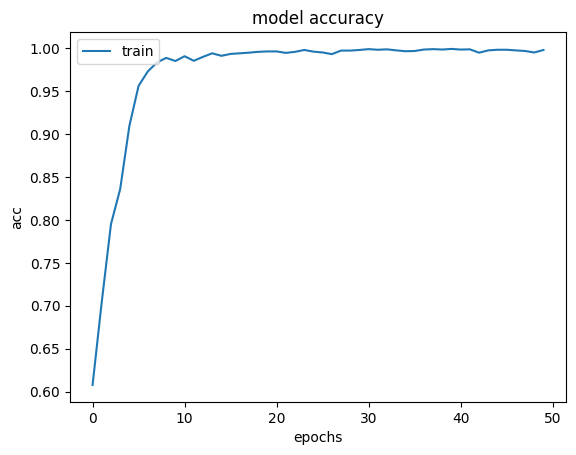

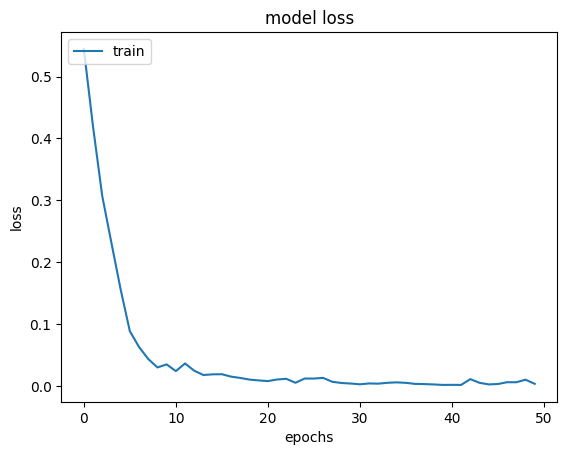

<Figure size 640x480 with 0 Axes>

In [81]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [82]:
# evaluate the model
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

129/129 - 1s - loss: 0.0020 - acc: 0.9988 - 810ms/epoch - 6ms/step
23/23 - 0s - loss: 1.3030 - acc: 0.7263 - 83ms/epoch - 4ms/step
Train: 0.999, Test: 0.7263


In [84]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs)

# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs, axis=1)
print(yhat_classes)

[[8.2077418e-07 9.9999893e-01 2.5279274e-07]
 [1.0000000e+00 1.7197949e-09 1.9997907e-08]
 [8.7431395e-09 1.0000000e+00 3.0461411e-09]
 ...
 [1.0000000e+00 1.4480847e-10 1.5095032e-09]
 [8.9509243e-08 9.9999988e-01 2.4017954e-08]
 [9.9999619e-01 2.2854038e-06 1.5603808e-06]]
[1 0 1 0 1 1 1 1 1 1 1 1 0 2 1 1 1 1 0 1 1 1 0 2 1 0 1 0 1 2 1 1 1 2 1 0 2
 0 1 1 1 1 2 1 0 1 1 1 0 1 2 1 1 2 1 0 1 1 0 1 0 0 0 0 1 1 1 1 0 2 1 1 1 1
 0 1 1 2 1 0 1 0 0 0 0 0 1 0 1 0 0 1 1 2 1 1 0 1 0 1 2 1 1 2 0 1 1 1 2 1 1
 1 2 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 1 0 1 0 1 1 1 1 1 1 1 1 1 2 1
 0 1 1 1 1 1 1 0 0 1 2 1 0 1 1 0 1 0 1 2 1 0 1 0 0 1 0 2 0 0 1 0 0 0 1 1 1
 2 1 0 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 2 1 1 0 1
 1 1 1 1 1 0 1 1 1 0 1 1 2 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1
 1 1 0 1 0 2 2 0 1 1 1 1 1 2 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 0 2 0 1 2 1
 1 1 0 1 0 1 1 1 1 2 1 0 1 0 1 2 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1
 1 0 0 1 0 1 1 0 0 1 0 1 1 1 0 1 1 0 1 1 2 1 1 0 

In [85]:
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0, 1, 0, 0, 2, 2, 1,
       0, 0, 1, 0, 1, 0, 0, 2, 1, 1, 0, 2, 1, 0, 2, 0, 1, 1, 0, 1, 2, 1,
       0, 1, 1, 1, 0, 0, 2, 1, 0, 2, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 2, 2, 1, 0, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 0,
       1, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 0, 0, 1, 0, 1, 0, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 1, 2, 1, 2, 1, 1, 0, 0, 1, 0, 2, 1,
       2, 0, 1, 1, 0, 2, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1,
       0, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 0, 1, 2, 0, 1, 0, 1, 1, 1, 1,
       1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       2, 1, 2, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 2, 1, 0, 1, 0, 2, 2, 1, 1, 1, 0, 1, 0,

In [87]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, yhat_classes)
cm

array([[132,  81,   2],
       [ 62, 348,  16],
       [ 10,  28,  48]])

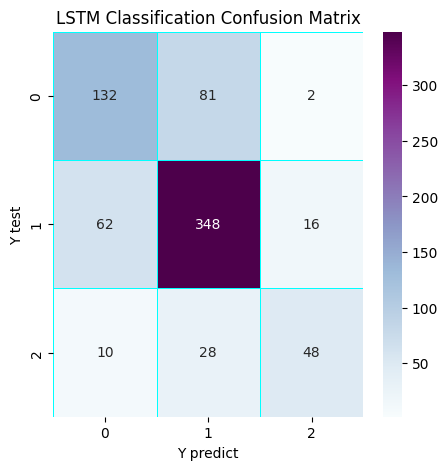

In [88]:
import seaborn as sns

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

Validation

In [89]:
validation_size = 610

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)

print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

4/4 [==============================] - 0s 5ms/step - loss: 1.4406 - acc: 0.7009
score: 1.44
acc: 0.70


In [90]:
model.save('Mymodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Test with new and different data set aside from the data to build the model.

note : sentiment = {'positive': 0,'neutral': 1,'negative':2}

In [94]:
message = ['Congratulations! you have won a $1,000 Walmart gift card']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 18ms/step
[[0.08718902 0.846509   0.0663019 ]] 1


In [95]:
message = ['such massive asteroid hit will certainly create new business opportunities']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 18ms/step
[[9.897601e-01 3.699276e-04 9.870039e-03]] 0


In [96]:
message = ['so does anyone else not open Snapchat anymore ? or is it just me ... ugh this so sad.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 25ms/step
[[1.1739704e-10 1.0000000e+00 4.4539174e-11]] 1


In [97]:
message = ['@elonmusk had a terrible experience with a very pushy sales guy from tesla Stanford shop while shopping for model x']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 19ms/step
[[9.9926311e-01 5.6100480e-04 1.7579274e-04]] 0


In [98]:
message = ['The local electronics industry is expected to remain stable amid layoff concerns surrounding Japanese electronics giants operating in the country, an official says.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 18ms/step
[[6.877064e-08 9.999999e-01 8.234156e-09]] 1


In [99]:
message = ['The local electronics industry is amid layoff concerns and last year has laid off tens of employees']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 25ms/step
[[1.2273449e-06 1.2471259e-06 9.9999750e-01]] 2
